In [1]:
import pandas as pd
import itertools, nltk, string 
import requests, re
from nltk import Tree
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
import os
import spacy
from gensim.models.wrappers import FastText
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve
import matplotlib.pyplot as plt
from math import exp, expm1, log, log10
from scipy.spatial.distance import euclidean
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import ast



from sklearn.metrics import average_precision_score,accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from collections import OrderedDict
import numpy as np
import math
import statistics
from pywsd.lesk import simple_lesk
from nltk.corpus import sentiwordnet as swn
from nltk.parse.corenlp import CoreNLPDependencyParser
parser = CoreNLPDependencyParser()



wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer("english")

Warming up PyWSD (takes ~10 secs)... took 8.212763786315918 secs.


In [2]:
#load model fast text
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
model_ftext = KeyedVectors.load_word2vec_format('../fasttext/wiki-news-300d-1M-subword.vec')

In [3]:
#load function

linking_verbs_be = [
    'be',
    'is',
    'are',
    'am',
    'was',
    'were',
    'can be',
    'could be',
    'will be',
    'would be',
    'shall be',
    'should be',
    'may be',
    'might be',
    'must be',
    'has been',
    'have been',
    'had been'
];

linking_verbs_v = [
    'feel',
    'look',
    'smell',
    'sound',
    'taste',
    'act',
    'appear',
    'become',
    'get',
    'grow',
    'prove',
    'remain', 
    'seem',
    'stay',
    'turn'
];

def check_is_noun(pos):
    return re.match('NN.*', pos)

def check_is_prp(pos):
    return re.match('PRP.*', pos)

def check_is_verb(pos):
    return re.match('VB.*', pos)

def check_is_adjective(pos):
    return re.match('JJ.*', pos)

def check_is_adverb(pos):
    return re.match('RB.*', pos)

def lemmatize(word, pos):
    tag = None#wn.NOUN
    if(check_is_noun(pos)):
        tag = wn.NOUN
    elif(check_is_verb(pos)):
        tag = wn.VERB
    elif(check_is_adjective(pos)):
        tag = wn.ADJ
    elif(check_is_adverb(pos)):
        tag = wn.ADV
    if tag:        
        lemma = wordnet_lemmatizer.lemmatize(word, tag)
    else:
        lemma = word
    return lemma


def preprocessing(sentence):
    res = sentence.replace("'m", "am").replace("n't", " not").replace("dont", "do not").replace("’s", ' is').replace("'s", ' is').replace("'ve", " have").lower()
    res = re.sub(r'\b\d+\b', 'NUM', res)
    res = re.sub(r'(.)\1{3,}', '', res)
    to_delete_punc = set(string.punctuation) - {',', '.', '(', ')', '-'} # remove comma and fullstop
    clean_tokens = [x for x in nltk.word_tokenize(res) if x not in to_delete_punc]

    return " ".join(clean_tokens)

def preprocessing_with_lemma(sentence):
    res = re.sub(r'[^\w\s]',' ', sentence.replace("'m", "am").replace("n't", "not").replace("dont", "do not").replace("'ve", " have").replace("'s", ' is').replace("’s", ' is')).lower()
    res = re.sub(r'(.)\1{3,}', '', res)
   
    #checking for parallel clauses
    #splitted = res.split(', and but')
    res = re.sub(r'\b\d+\b', '', res)
    tagged_words = pos_tag(res.encode())
    lemma = []
    for word, pos in tagged_words:
        if word not in stopWords:
            lemma.append(lemmatize(word, pos)) 
        
    return " ".join(lemma)
    
def pos_tag(sentence):
    url = "http://localhost:9000"
    request_params = {"annotators": "pos"}
    r = requests.post(url, data=sentence, params=request_params, timeout=120)
    try:
        results = r.json()['sentences'][0]['tokens']
        res = []
        for pos in results:
            res.append((pos['word'], pos['pos']))
        return res
    except Exception as e:
        print(e)
        return []
    
def get_tregex(text, tregex):
    url = "http://localhost:9000/tregex"
    request_params = {"pattern": tregex}
    r = requests.post(url, data=text, params=request_params, timeout=120)
    try:
        return r.json()['sentences'][0]
    except:
        return []

def sentence_from_tree(s):
    pattern = r'(?<= )[a-zA-Z,.].*?(?=\))'
    replaced = s.replace('\r\n', '')
    res = ' '.join(re.findall(pattern, replaced))
    return res
        
def sentence_type(clauses):
    IC = 0
    DC = 0
    for clause in clauses:
        if(clause[1] == 'IC'):
            IC += 1
        elif(clause[1] == 'DC'):
            DC += 1

    if IC == 1 and DC == 0:
        return 'simple_sentence'
    elif IC >= 2 and DC == 0:
        return 'compound_sentence'
    elif IC ==1 and DC >= 1:
        return 'complex_sentence'
    elif IC > 1 and DC >= 1:
        return 'compound_complex_sentence'
    else:
        return 'phrase'
    

In [146]:
negation = [
    "afraid",
    "can't",
    "cannot",
    "deny",
    "mean",
    "negate",
    "negation",
    "but",
    "negative",
    "neither",
    "never",
    "no",
    "non",
    "none",
    "nor",
    "not",
    "nothing",
    "refusal",
    "refuse",
    "reject",
    "rejection",
  #  'even',
  #  'although'
]


def analyse_file(key, lines, lemma_lines, usingSynonym=False):    
    radii = get_TDOC(lines, key, lemma_lines, usingSynonym)    
    return radii

def get_TDOC(lines, key, lemma_lines, usingSynonym=False, synonym_keys={}):
    freq = {'Init': 0}              #Number of times context term occurs with key
    freq.clear()
    prohib = ['even', 'main'] #stopWords
    for line in lemma_lines:
        words = line.split(" ")
        tagged = pos_tag(line)
       # print('wwwwwwwwww', words)
        if key in words:
            if usingSynonym:
             #   print(key, 'tdoc')
                #get synonym
                syn_c=[]
                for context, pos in tagged:
                    try:
                        #synonyms = model_ftext.most_similar(context, topn=2)
                        synonym_keys.setdefault(context, [])
                                    
                        #for syn in synonyms:
                        #    if(not '-' in syn[0]):
                        #        lemma = lemmatize(syn[0], pos)
                                    
                        #        if lemma not in words:
                        #            if lemma not in synonym_keys[context]:
                        #                synonym_keys[context].append(lemma)
                                    
                        #            syn_c.append(lemma)                    
                        for syn in wn.synsets(context):
                            if(syn.pos() != wn.NOUN):
                                for l in syn.lemmas():
                                    if not '-' in l.name() and l.name() not in synonym_keys[context]:
                                        synonym_keys[context].append(l.name())
                                        syn_c.append(l.name())

                    except:
                        #print(context)
                        #print('error')
                        pass
                    
                for c in syn_c:
                    words.append(c)
          #  print('keluar', key)        
            for context in words:
                flag=0
                for i in prohib:
                    if i == context:
                        flag=1
                        break
                if flag==0 and context!=key:# and context in op_set:
                    freq.setdefault(context, 0)
                    freq[context] = freq.get(context) + 1
                                           
    N = 0                           #Total Number of terms in Document
    for line in lemma_lines:
        words = line.split(" ")
        N += len(words)

    Nci = {'Init': 0}               #Total terms that occur with context term
    Nci.clear()
    for context in freq.keys():
        for line in lemma_lines:
            words = line.split(" ")
            if context in words:
                Nci.setdefault(context, 0)
                Nci[context] += len(words)
                
    if usingSynonym:
        for context in freq.keys():
            if context not in Nci.keys():
                Nci.setdefault(context, 1)

    radii = {'Init': 0}             #Get Radius of context term with TDOC formula
    radii.clear()
    #print('freq', freq, 'freq')
    #print('N', N)
    #print('NCI', Nci)
    df = pd.DataFrame(columns=['c', 'm', 'N', 'Nc', 'f', 'N/Nc', 'log(N/Nc)', 'fxlog(N/Nc)', '/4'])
    max_value = 0
    for term in freq.keys():
        radii[term] = (freq[term]*(log(N/Nci[term])))
        
        if radii[term] > max_value:
            max_value = radii[term]
        
    for term in freq.keys():
        radii[term] = radii[term]/max_value
        
        df = df.append({'c': term,
                'm': key,
                'N': N,
                'Nc': Nci[term],
                'f': freq[term],
                'N/Nc': "{0:.2f}".format(N/Nci[term]),
                'log(N/Nc)': "{0:.2f}".format(log(N/Nci[term])),
                'fxlog(N/Nc)': "{0:.2f}".format(freq[term]*(log(N/Nci[term]))),
                'normalisasi': "{0:.2f}".format((freq[term]*(log(N/Nci[term])))/max_value)
               }, ignore_index=True)
    
    #df.to_excel("tdoc2.xlsx")
    return radii, synonym_keys                    #Returns entire set of context terms related to key

def get_theta(key, sentences):
    scores = []
    for sentence in sentences:
        flag = True
        
        pp_tagged = pos_tag(sentence)
        tagged = ('','')
        for p in pp_tagged:
            if p[0] == key:
                tagged = p
        if tagged == ('', ''):
            flag = False
        
        ambiguous = tagged[0]
        tag = tagged[1]
        pos = ''

        if 'NN' in tag or 'NNS' in tag:
            pos = 'n'
        elif 'VB' in tag:
            pos = 'v'
        elif 'VBG' in tag:
            pos = 'v'
        elif 'JJ' in tag:
            pos = 'a'
        elif 'RB' in tag:
            pos = 'r'
        else:
            flag = False

        if flag:
            if ambiguous in negation or pos == 'n' or pos == 'v' or pos == 'r':
                scores.append(0)
                continue
             
            try:
                 answer = simple_lesk(sentence, ambiguous, pos)
            except Exception as e:
                print(e)
                answer = None
            if answer:
                score = swn.senti_synset(answer.name())
                endscore = 0
                if score.pos_score() > score.neg_score():
                    endscore = score.pos_score()
                elif score.neg_score() > score.pos_score():
                    endscore = score.neg_score() * (-1)
                else:
                    endscore = 0
                
                words = sentence.split(' ')
                word_around = []
                for x in range(0, len(words)):
                    if words[x] in string.punctuation:
                        continue
                    try:
                        if (words[x+1] == key) or (words[x+2] == key) or (words[x+3] == key) or (words[x+4] == key):
                            word_around.append(words[x])
                        elif (words[x-1] == key):
                            word_around.append(words[x])
                    except:
                        pass
                #print(word_around, key)
                for neg in negation:
                    if neg in word_around:
                       # print('masuk', endscore, key, score)
                        endscore *= (-1)
                        break
                        
                scores.append(endscore)
            else:
                scores.append(0)
        else:
            scores.append(0)
            
    final_score = np.average(scores)
    return np.pi * final_score

def prior_sentiment(radii, key, all_sentences, sentence_lemmas, usingSynonym=False, synonym_keys={}):
    theta = {'Init': 0}
    theta.clear()
    #print('masuk prior', synonym_keys)
    for word in radii.keys():
        sentences = []
        for sentence, sentence_lemma in zip(all_sentences, sentence_lemmas):
            words = sentence_lemma.split(' ')
            if key in words:
                if usingSynonym:
                    #find value first
                    child_syns = synonym_keys[key]
                    
                    if word in child_syns:
                        #print('masuk synonym')
                        #add words with word
                        words.append(word)
                        #replace sentenc key_syn with word
                        sentence = sentence.replace(key, word)
                        #print('sentence baru', sentence)
                        #print('words baru', words)
                        #print('keluar synonym')
                        
                if (word in words):
                    sentences.append(sentence)
            #print("===", word, words, key, "===")
            #if (word in words) and (key in words):
                #sentences.append(sentence)
        
        #print("+++", sentences, "+++")
        if(len(sentences) > 0):
            filter = get_theta(word, sentences)            #if function returns 0 word does not exist in lexicon
            #print('hore')
        else:
            #print('kok bisa', word)
            filter = 0.0
        theta[word] = filter
        #print('---', theta[word], '---')
        
    return theta

In [5]:
def graph(radii, theta, key, show_pic=False):
    i=0
    a=[]
    b=[]
    rad=list(radii.values())
    theta1=list(theta.values())
    index = []
    while(i<len(radii)):
        if(theta1[i] != 0):
            a.append(rad[i]*math.cos(theta1[i]))
            b.append(rad[i]*math.sin(theta1[i]))
            index.append(i)
        i+=1 
        
    if show_pic:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot([0,0],[-1,1])
        plt.plot([-1,1],[0,0])
        plt.axis([-1,1,-1,1])

        plt.scatter(a,b,label="circles",color="r",marker="o",s=10)
        q = 0
        rad2=list(radii.keys())
        for i,j,z in zip(a,b, index):
            ax.annotate('%s' %rad2[z], xy=(i,j), xytext=(15,0), textcoords='offset points')
            q = q+1    
        
        points = []
        for x,y in zip(a,b):
            points.append([x, y])
        
        if(len(points) == 0):
            points.append([0, 0])
            
        senti_x, senti_y = geometric_medianX(points)
        plt.scatter(senti_x,senti_y,label="circles",color="b",marker="o",s=10)
        ax.annotate('%s' % '', xy=(senti_x,senti_y), xytext=(15,0), textcoords='offset points')
           
        ax.add_artist(plt.Circle((0,0),1.0,color='b',fill=False))
        plt.xlabel('Sentiment Strength')
        plt.ylabel('Orientation')
        plt.title(key)
        plt.savefig("graph.png")
    
    return a,b

In [6]:
def geometric_medianX(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

In [151]:
def senti(keys, lines, lemma_lines, usingSynonym=False):
    points_k = []
    for key in keys:
        radii, synonym_keys = analyse_file(key, lines, lemma_lines, usingSynonym)
        theta = prior_sentiment(radii, key, lines, lemma_lines, usingSynonym, synonym_keys)
        a,b = graph(radii, theta, key)
        points = []
        for x,y in zip(a,b):
            points.append([x, y])
        
        if(len(points) == 0):
            points.append([0, 0])
        senti_x, senti_y = geometric_medianX(points)
        
        points_k.append([senti_x, senti_y])
    
    sentiment_strength, sentiment_orientation = geometric_medianX(points_k)
    #print(sentiment_strength, sentiment_orientation)
    if sentiment_orientation > 0:
        return 'positive'
    else:
        return 'negative'

In [8]:
def categorize_dataset(category, dataset):
    return dataset[dataset.apply(lambda x: set([category]).issubset(ast.literal_eval(x['entity_prediction'])), axis=1)].reset_index(drop=True)

In [96]:
def confusion_metrix_sentiment_senticircle(selected, dataset):
    tp = 0
    tn = 0
    fp = 0
    fn = 0 
    
    for i, predictions in enumerate(dataset['opinion_prediction']):
        target = dataset['polarity'][i]
        
        entity_predictions =  ast.literal_eval(dataset['entity_prediction'][i])
        #print(entity_predictions)
        entities = dataset['entity'][i].split(',')
        pred_selected = False
        actual_selected = False
        
        for index, pred in enumerate(predictions):
           # print(pred)
            if entity_predictions[index] == selected and pred == 'positive':
                pred_selected = True
        
        for index, ent in enumerate(target.split(',')):
            if entities[index] == selected and ent == 'positive':
                actual_selected = True
                
        #print(pred_selected, actual_selected, entity_predictions, entities, target, predictions)
        if pred_selected and actual_selected:
            tp +=1
        elif pred_selected and not actual_selected:   
            fp += 1
        elif not pred_selected and actual_selected:
            fn += 1
        elif not pred_selected and not actual_selected:
            tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return tp, tn, fp, fn, precision, recall, ((precision * recall) / (precision + recall)) * 2

In [10]:
data_ac3 = pd.read_csv('ac3.csv')

In [11]:
data_food = categorize_dataset('FOOD', data_ac3)

In [156]:
data_value = pd.read_csv('value.csv')#categorize_dataset('VALUE', data_ac3)

In [13]:
data_ambience = categorize_dataset('AMBIENCE', data_ac3)

In [14]:
data_service = categorize_dataset('SERVICE', data_ac3)

SA1

In [107]:
op_pred = []

for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [108]:
op_pred = []

for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_ambience['preprocessed_sentence'].tolist(), data_ambience['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [109]:
op_pred = []

for i, opinion_sents in enumerate(data_servicervice['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_service['preprocessed_sentence'].tolist(), data_service['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [157]:
op_pred = []

for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred

In [158]:
sentiment_value = (confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

0.7005649717514124


In [112]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('AMBIENCE', data_ambience)[6])# + confusion_metrix_sentiment_senticircle('negative', data_ambience)[6] ) / 2
print(sentiment_ambience)

0.7813411078717201


In [113]:
sentiment_food = (confusion_metrix_sentiment_senticircle('FOOD', data_food)[6])# + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2
print(sentiment_food)

0.6958105646630237


In [114]:
sentiment_service = (confusion_metrix_sentiment_senticircle('SERVICE', data_service)[6])# + confusion_metrix_sentiment_senticircle('negative', data_service)[6] ) / 2
print(sentiment_service)

0.7982062780269059


In [159]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

0.7439807305782655

SA2

In [164]:
op_pred = []

for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist(), True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [165]:
op_pred = []

for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_ambience['preprocessed_sentence'].tolist(), data_ambience['preprocessed_sentence_lemma'].tolist(), True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [166]:
op_pred = []

for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist(), True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred

In [ ]:
op_pred = []

for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_service['preprocessed_sentence'].tolist(), data_service['preprocessed_sentence_lemma'].tolist(), True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [ ]:
sentiment_value = (confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

In [ ]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('AMBIENCE', data_ambience)[6])# + confusion_metrix_sentiment_senticircle('negative', data_ambience)[6] ) / 2
print(sentiment_ambience)

In [ ]:
sentiment_food = (confusion_metrix_sentiment_senticircle('FOOD', data_food)[6])# + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2
print(sentiment_food)

In [ ]:
sentiment_service = (confusion_metrix_sentiment_senticircle('SERVICE', data_service)[6])# + confusion_metrix_sentiment_senticircle('negative', data_service)[6] ) / 2
print(sentiment_service)

In [ ]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

In [155]:
data_value.to_csv('hasil_value.csv')

'negative'

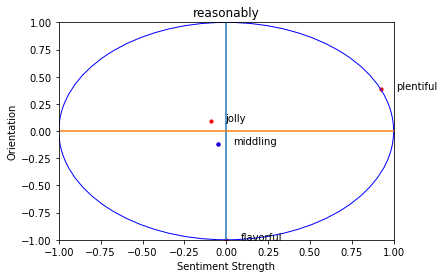

In [150]:
senti(['reasonably'], data_value['preprocessed_sentence'], data_value['preprocessed_sentence_lemma'], True)

freq {'bad': 15, 'food': 17, 'price': 18, 'good': 2, 'would': 1, 'come': 1, 'back': 1, 'quality': 2, 'horrible': 1, 'takeout': 1, 'great': 1, 'since': 1, 'give': 1, 'tupperware': 1, 'well': 1, 'though': 1, 'seafood': 1} freq
N 2734
NCI {'bad': 162, 'food': 1124, 'price': 340, 'good': 485, 'would': 94, 'come': 70, 'back': 33, 'quality': 30, 'horrible': 34, 'takeout': 8, 'great': 405, 'since': 32, 'give': 28, 'tupperware': 8, 'well': 59, 'though': 73, 'seafood': 25}
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high', 'price'] high ===
=== bad ['bad', 'food', 'high',

=== bad ['also', 'sandwich', 'near', 'didnot', 'come', 'anything', 'like', 'chip', 'side'] high ===
=== bad ['food', 'tasty', 'portion', 'size', 'appropriate'] high ===
=== bad ['food', 'horrible'] high ===
=== bad ['fish', 'fresh'] high ===
=== bad ['menu', 'limited', 'almost', 'dish', 'excellent'] high ===
=== bad ['lobster', 'sandwich', 'good', 'spaghetti', 'scallop', 'shrimp', 'great'] high ===
=== bad ['service', 'good', 'ambience', 'good', 'date', 'group', 'outing'] high ===
=== bad ['even', 'though', 'good', 'seafood', 'price', 'high'] high ===
=== bad ['lobster', 'sandwich', 'although', 'good', 'nearly', 'enough', 'warrant', 'price'] high ===
=== bad ['food', 'delicious', 'halibut', 'special', 'husband', 'steak', 'service', 'top', 'notch'] high ===
=== bad ['recommend', 'jelly', 'fish', 'drunken', 'chicken', 'soupy', 'dumpling', 'certainly', 'stir', 'fry', 'blue', 'crab'] high ===
=== bad ['food', 'cheap', 'waiter', 'nice'] high ===
=== bad ['frequent', 'ino', 'several', 'year'

=== bad ['best', 'reuben', 'sandwich', 'ever'] high ===
=== bad ['food', 'fresh', 'sauce', 'bland', 'oily'] high ===
=== bad ['pizza', 'little', 'soggy'] high ===
=== bad ['ravioli', 'good', 'say', 'find', 'everything', 'bit', 'overpriced'] high ===
=== bad ['authentic', 'pakistani', 'food'] high ===
=== bad ['straight', 'cheap', 'good', 'food'] high ===
=== bad ['best', 'pad', 'thai', 'ever'] high ===
=== bad ['food', 'actually', 'aweful'] high ===
=== bad ['mussles', 'fishy', 'thing', 'ever', 'taste', 'seabass', 'bland', 'goat', 'cheese', 'salad', 'miss', 'goat', 'cheese', 'penne', 'w', 'chicken', 'bone', 'itit', 'disgust'] high ===
=== bad ['food', 'amazing', 'rich', 'pasta', 'fresh', 'doughy', 'pizza'] high ===
=== bad ['really', 'recommend', 'simple', 'unda', 'egg', 'roll'] high ===
=== bad ['delicate', 'spice', 'onion', 'egg', 'kick', 'as', 'roti'] high ===
=== bad ['food', 'good', 'ever'] high ===
=== bad ['go', 'last', 'night', 'nice', 'decor', 'good', 'service', 'food', 'surpr

=== food ['mine', 'little', 'burnt', 'still', 'delicious', 'goat', 'cheese', 'panchetta', 'raddichio', 'kind', 'bitter', 'though'] high ===
=== food ['friend', 'get', 'mushroom', 'pizza', 'taste', 'good'] high ===
=== food ['food', 'authentic', 'italian', 'delicious'] high ===
=== food ['pizza', 'terrific', 'homemade', 'pasta'] high ===
=== food ['ambience', 'delightful', 'service', 'impeccable'] high ===
=== food ['iam', 'still', 'mad', 'pay', 'lousy', 'food'] high ===
=== food ['hanger', 'steak', 'like', 'rubber', 'tuna', 'flavorless', 'mention', 'taste', 'like', 'thaw'] high ===
=== food ['service', 'also', 'horrible', 'ambience', 'great'] high ===
=== food ['first', 'time', 'write', 'review', 'restaurant', 'food', 'service', 'excellent'] high ===
=== food ['filet', 'mignon', 'dish', 'superb'] high ===
=== food ['like', 'ambience', 'dark', 'original'] high ===
=== food ['sushi', 'amazing'] high ===
=== food ['affordable', 'excellent', 'ambience'] high ===
=== food ['one', 'meal', 'e

hore
--- 0.0 ---
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['bad', 'food', 'high', 'price'] high ===
=== price ['price', 'high', 'food', 'good', 'would', 'come', 'back'] high ===
=== price ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== price ['food', 'flavorful', 'plentiful', 're

=== price ['sapphire', 'twice', 'time', 'food', 'fine', 'good'] high ===
=== price ['best', 'reuben', 'sandwich', 'ever'] high ===
=== price ['food', 'fresh', 'sauce', 'bland', 'oily'] high ===
=== price ['pizza', 'little', 'soggy'] high ===
=== price ['ravioli', 'good', 'say', 'find', 'everything', 'bit', 'overpriced'] high ===
=== price ['authentic', 'pakistani', 'food'] high ===
=== price ['straight', 'cheap', 'good', 'food'] high ===
=== price ['best', 'pad', 'thai', 'ever'] high ===
=== price ['food', 'actually', 'aweful'] high ===
=== price ['mussles', 'fishy', 'thing', 'ever', 'taste', 'seabass', 'bland', 'goat', 'cheese', 'salad', 'miss', 'goat', 'cheese', 'penne', 'w', 'chicken', 'bone', 'itit', 'disgust'] high ===
=== price ['food', 'amazing', 'rich', 'pasta', 'fresh', 'doughy', 'pizza'] high ===
=== price ['really', 'recommend', 'simple', 'unda', 'egg', 'roll'] high ===
=== price ['delicate', 'spice', 'onion', 'egg', 'kick', 'as', 'roti'] high ===
=== price ['food', 'good', 

=== good ['authentic', 'thai', 'food', 'look', 'toon'] high ===
=== good ['try', 'pad', 'thai', 'sample', 'anything', 'appetizer', 'menu', 'delicious'] high ===
=== good ['brioche', 'lolly', 'party', 'favor', 'cute', 'sweet', 'touch', 'memorable', 'meal'] high ===
=== good ['service', 'good', 'food', 'wonderful'] high ===
=== good ['try', 'caviar', 'try', 'salmon', 'crab', 'salad', 'good'] high ===
=== good ['food', 'yummy', 'especially', 'cook', 'perfection', 'mussel', 'spicy', 'tomato', 'sauce', 'shoestring', 'crispy', 'fry'] high ===
=== good ['get', 'completely', 'delish', 'martini', 'glass', 'drink', 'recommend', 'vanilla', 'shanty', 'great', 'homey', 'setting', 'great', 'music'] high ===
=== good ['love', 'thai'] high ===
=== good ['imagine', 'good', 'indian', 'food', 'city'] high ===
=== good ['food', 'inconsistent'] high ===
=== good ['food', 'excellent'] high ===
=== good ['daring', 'try', 'balsamic', 'vinegar', 'icecream', 'wonderful'] high ===
=== good ['wait', 'long', 'dim'

=== would ['cozy', 'place', 'great', 'service', 'amazing', 'pizza'] high ===
=== would ['price', 'high', 'quality', 'food', 'horrible'] high ===
=== would ['food', 'lousy', 'sweet', 'salty', 'portion', 'tiny'] high ===
=== would ['eat', 'saul', 'many', 'time', 'food', 'always', 'consistently', 'outrageously', 'good'] high ===
=== would ['duck', 'confit', 'always', 'amazing', 'foie', 'gras', 'terrine', 'fig', 'world'] high ===
=== would ['chow', 'fun', 'dry', 'pork', 'shu', 'mai', 'usually', 'greasy', 'share', 'table', 'loud', 'rude', 'family'] high ===
=== would ['duck', 'breast', 'special', 'last', 'visit', 'incredible'] high ===
=== would ['food', 'average', 'thai', 'fusion', 'stuff', 'bit', 'sweet', 'every', 'thing', 'serve', 'sweet'] high ===
=== would ['thing', 'moderately', 'enjoy', 'grilled', 'chicken', 'special', 'edamame', 'puree'] high ===
=== would ['never', 'edamame', 'pureed', 'think', 'innovative', 'tasty', 'could', 'use', 'bit', 'salt'] high ===
=== would ['spicy', 'tuna

=== would ['ambiance', 'atmosphere', 'great', 'food', 'service', 'could', 'lot', 'good'] high ===
=== would ['sapphire', 'twice', 'time', 'food', 'fine', 'good'] high ===
=== would ['best', 'reuben', 'sandwich', 'ever'] high ===
=== would ['food', 'fresh', 'sauce', 'bland', 'oily'] high ===
=== would ['pizza', 'little', 'soggy'] high ===
=== would ['ravioli', 'good', 'say', 'find', 'everything', 'bit', 'overpriced'] high ===
=== would ['authentic', 'pakistani', 'food'] high ===
=== would ['straight', 'cheap', 'good', 'food'] high ===
=== would ['best', 'pad', 'thai', 'ever'] high ===
=== would ['food', 'actually', 'aweful'] high ===
=== would ['mussles', 'fishy', 'thing', 'ever', 'taste', 'seabass', 'bland', 'goat', 'cheese', 'salad', 'miss', 'goat', 'cheese', 'penne', 'w', 'chicken', 'bone', 'itit', 'disgust'] high ===
=== would ['food', 'amazing', 'rich', 'pasta', 'fresh', 'doughy', 'pizza'] high ===
=== would ['really', 'recommend', 'simple', 'unda', 'egg', 'roll'] high ===
=== woul

=== come ['scallop', 'appetizer', 'delicious', 'sauce', 'wonderful'] high ===
=== come ['love', 'food'] high ===
=== come ['place', 'get', 'yummy', 'authentic', 'japanese', 'comfort', 'food'] high ===
=== come ['great', 'food', 'good', 'size', 'menu', 'great', 'service', 'unpretensious', 'setting'] high ===
=== come ['dish', 'offer', 'unique', 'tasty', 'fresh', 'lamb', 'sausage', 'sardine', 'biscuit', 'large', 'whole', 'shrimp', 'amazing', 'pistachio', 'ice', 'cream', 'best', 'fresh', 'ever'] high ===
=== come ['service', 'excellent', 'food', 'delicious'] high ===
=== come ['particular', 'sushi', 'please', 'every', 'choice', 'include', 'ceviche', 'mix', 'special', 'crab', 'dumpling', 'assorted', 'sashimi', 'sushi', 'roll', 'two', 'type', 'sake', 'banana', 'tempura'] high ===
=== come ['average', 'good', 'thai', 'food', 'terrible', 'delivery'] high ===
=== come ['food', 'arrive', 'minute', 'call', 'cold', 'soggy'] high ===
=== come ['helpful', 'suggest', 'us', 'drink', 'help', 'us', 'or

=== back ['price', 'affordable', 'quality', 'food', 'bad'] high ===
=== back ['cozy', 'place', 'great', 'service', 'amazing', 'pizza'] high ===
=== back ['price', 'high', 'quality', 'food', 'horrible'] high ===
=== back ['food', 'lousy', 'sweet', 'salty', 'portion', 'tiny'] high ===
=== back ['eat', 'saul', 'many', 'time', 'food', 'always', 'consistently', 'outrageously', 'good'] high ===
=== back ['duck', 'confit', 'always', 'amazing', 'foie', 'gras', 'terrine', 'fig', 'world'] high ===
=== back ['chow', 'fun', 'dry', 'pork', 'shu', 'mai', 'usually', 'greasy', 'share', 'table', 'loud', 'rude', 'family'] high ===
=== back ['duck', 'breast', 'special', 'last', 'visit', 'incredible'] high ===
=== back ['food', 'average', 'thai', 'fusion', 'stuff', 'bit', 'sweet', 'every', 'thing', 'serve', 'sweet'] high ===
=== back ['thing', 'moderately', 'enjoy', 'grilled', 'chicken', 'special', 'edamame', 'puree'] high ===
=== back ['never', 'edamame', 'pureed', 'think', 'innovative', 'tasty', 'could'

=== back ['warm', 'friendly', 'winter', 'terrific', 'outdoor', 'seating', 'warm', 'month'] high ===
=== back ['food', 'great', 'good', 'selecion', 'wine', 'reasonable', 'price'] high ===
=== back ['ambiance', 'atmosphere', 'great', 'food', 'service', 'could', 'lot', 'good'] high ===
=== back ['sapphire', 'twice', 'time', 'food', 'fine', 'good'] high ===
=== back ['best', 'reuben', 'sandwich', 'ever'] high ===
=== back ['food', 'fresh', 'sauce', 'bland', 'oily'] high ===
=== back ['pizza', 'little', 'soggy'] high ===
=== back ['ravioli', 'good', 'say', 'find', 'everything', 'bit', 'overpriced'] high ===
=== back ['authentic', 'pakistani', 'food'] high ===
=== back ['straight', 'cheap', 'good', 'food'] high ===
=== back ['best', 'pad', 'thai', 'ever'] high ===
=== back ['food', 'actually', 'aweful'] high ===
=== back ['mussles', 'fishy', 'thing', 'ever', 'taste', 'seabass', 'bland', 'goat', 'cheese', 'salad', 'miss', 'goat', 'cheese', 'penne', 'w', 'chicken', 'bone', 'itit', 'disgust'] h

=== quality ['pizza', 'terrific', 'homemade', 'pasta'] high ===
=== quality ['ambience', 'delightful', 'service', 'impeccable'] high ===
=== quality ['iam', 'still', 'mad', 'pay', 'lousy', 'food'] high ===
=== quality ['hanger', 'steak', 'like', 'rubber', 'tuna', 'flavorless', 'mention', 'taste', 'like', 'thaw'] high ===
=== quality ['service', 'also', 'horrible', 'ambience', 'great'] high ===
=== quality ['first', 'time', 'write', 'review', 'restaurant', 'food', 'service', 'excellent'] high ===
=== quality ['filet', 'mignon', 'dish', 'superb'] high ===
=== quality ['like', 'ambience', 'dark', 'original'] high ===
=== quality ['sushi', 'amazing'] high ===
=== quality ['affordable', 'excellent', 'ambience'] high ===
=== quality ['one', 'meal', 'edible', 'bland', 'make', 'weird', 'rosemary', 'orange', 'flavoring'] high ===
=== quality ['fish', 'overdo'] high ===
=== quality ['someone', 'else', 'recommend', 'dessert', 'also', 'leave'] high ===
=== quality ['never', 'bad', 'service', 'fish

=== quality ['warm', 'friendly', 'winter', 'terrific', 'outdoor', 'seating', 'warm', 'month'] high ===
=== quality ['food', 'great', 'good', 'selecion', 'wine', 'reasonable', 'price'] high ===
=== quality ['ambiance', 'atmosphere', 'great', 'food', 'service', 'could', 'lot', 'good'] high ===
=== quality ['sapphire', 'twice', 'time', 'food', 'fine', 'good'] high ===
=== quality ['best', 'reuben', 'sandwich', 'ever'] high ===
=== quality ['food', 'fresh', 'sauce', 'bland', 'oily'] high ===
=== quality ['pizza', 'little', 'soggy'] high ===
=== quality ['ravioli', 'good', 'say', 'find', 'everything', 'bit', 'overpriced'] high ===
=== quality ['authentic', 'pakistani', 'food'] high ===
=== quality ['straight', 'cheap', 'good', 'food'] high ===
=== quality ['best', 'pad', 'thai', 'ever'] high ===
=== quality ['food', 'actually', 'aweful'] high ===
=== quality ['mussles', 'fishy', 'thing', 'ever', 'taste', 'seabass', 'bland', 'goat', 'cheese', 'salad', 'miss', 'goat', 'cheese', 'penne', 'w', 

=== horrible ['food', 'authentic', 'italian', 'delicious'] high ===
=== horrible ['pizza', 'terrific', 'homemade', 'pasta'] high ===
=== horrible ['ambience', 'delightful', 'service', 'impeccable'] high ===
=== horrible ['iam', 'still', 'mad', 'pay', 'lousy', 'food'] high ===
=== horrible ['hanger', 'steak', 'like', 'rubber', 'tuna', 'flavorless', 'mention', 'taste', 'like', 'thaw'] high ===
=== horrible ['service', 'also', 'horrible', 'ambience', 'great'] high ===
=== horrible ['first', 'time', 'write', 'review', 'restaurant', 'food', 'service', 'excellent'] high ===
=== horrible ['filet', 'mignon', 'dish', 'superb'] high ===
=== horrible ['like', 'ambience', 'dark', 'original'] high ===
=== horrible ['sushi', 'amazing'] high ===
=== horrible ['affordable', 'excellent', 'ambience'] high ===
=== horrible ['one', 'meal', 'edible', 'bland', 'make', 'weird', 'rosemary', 'orange', 'flavoring'] high ===
=== horrible ['fish', 'overdo'] high ===
=== horrible ['someone', 'else', 'recommend', '

=== takeout ['bad', 'food', 'high', 'price'] high ===
=== takeout ['bad', 'food', 'high', 'price'] high ===
=== takeout ['bad', 'food', 'high', 'price'] high ===
=== takeout ['bad', 'food', 'high', 'price'] high ===
=== takeout ['bad', 'food', 'high', 'price'] high ===
=== takeout ['bad', 'food', 'high', 'price'] high ===
=== takeout ['bad', 'food', 'high', 'price'] high ===
=== takeout ['price', 'high', 'food', 'good', 'would', 'come', 'back'] high ===
=== takeout ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== takeout ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== takeout ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== takeout ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== takeout ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== takeout ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== takeout ['food', 'flavorful', 'plentiful', 'reasonably', 'price'

=== takeout ['back', 'garden', 'sit', 'area', 'pleasant', 'see', 'personal', 'herb', 'garden'] high ===
=== takeout ['lobster', 'sandwich', 'fantastic'] high ===
=== takeout ['scallop', 'appetizer', 'delicious', 'sauce', 'wonderful'] high ===
=== takeout ['love', 'food'] high ===
=== takeout ['place', 'get', 'yummy', 'authentic', 'japanese', 'comfort', 'food'] high ===
=== takeout ['great', 'food', 'good', 'size', 'menu', 'great', 'service', 'unpretensious', 'setting'] high ===
=== takeout ['dish', 'offer', 'unique', 'tasty', 'fresh', 'lamb', 'sausage', 'sardine', 'biscuit', 'large', 'whole', 'shrimp', 'amazing', 'pistachio', 'ice', 'cream', 'best', 'fresh', 'ever'] high ===
=== takeout ['service', 'excellent', 'food', 'delicious'] high ===
=== takeout ['particular', 'sushi', 'please', 'every', 'choice', 'include', 'ceviche', 'mix', 'special', 'crab', 'dumpling', 'assorted', 'sashimi', 'sushi', 'roll', 'two', 'type', 'sake', 'banana', 'tempura'] high ===
=== takeout ['average', 'good',

=== great ['bad', 'service', 'bad', 'food'] high ===
=== great ['pizza', 'delicious', 'use', 'fresh', 'mozzarella', 'instead', 'cheap', 'frozen', 'shredded', 'cheese', 'common', 'pizzaria'] high ===
=== great ['two', 'complaint', 'appetizer', 'selection', 'stink', 'would', 'nice', 'get', 'mozzarella', 'stick', 'menu'] high ===
=== great ['wait', 'staff', 'blantently', 'unappreciative', 'business', 'best', 'pie', 'uws'] high ===
=== great ['far', 'bad', 'salad', 'fast', 'food', 'restaurant'] high ===
=== great ['live', 'upstate', 'would', 'buy', 'freeze', 'bagel', 'would', 'still', 'good', 'else'] high ===
=== great ['food', 'good', 'well', 'consider', 'try', 'budget', 'selection', 'though', 'wish', 'pork', 'belly', 'order', 'roasted', 'bit', 'longer', 'fat', 'melt', 'mouth', 'experience'] high ===
=== great ['traditional', 'french', 'decour', 'pleasant', 'though', 'hall', 'rather', 'noisy', 'restaurant', 'full', 'raise', 'voice', 'able', 'maintain', 'conversation'] high ===
=== great [

=== great ['kitchen', 'food', 'delicious', 'sushi', 'world'] high ===
=== great ['mizu', 'home', 'creative', 'unique', 'roll', 'find', 'anywhere', 'else'] high ===
=== great ['cuisine', 'best', 'around', 'service', 'always', 'attentive', 'charming'] high ===
=== great ['order', 'smoked', 'salmon', 'roe', 'appetizer', 'flavor'] high ===
=== great ['entree', 'bland', 'small', 'dessert', 'inspire'] high ===
=== great ['view', 'spectacular', 'food', 'great'] high ===
=== great ['authentic', 'taiwanese', 'food', 'cheapwhat', 'could', 'ask'] high ===
=== great ['cold', 'appetizer', 'dish', 'taste', 'like', 'way', 'remember', 'taste', 'grow', 'taiwan'] high ===
=== great ['delicious', 'simple', 'food', 'nice', 'outdoor', 'atmosphere'] high ===
=== great ['really', 'like', 'scallop', 'mahi', 'mahi', 'saffron', 'risotto', 'yum'] high ===
=== great ['delicious', 'crab', 'cake'] high ===
=== great ['even', 'food', 'wasnot', 'good', 'garden', 'great', 'place', 'sit', 'outside', 'relax'] high ===
=

=== since ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== since ['martini', 'amazing', 'price', 'expensive'] high ===
=== since ['great', 'service', 'food', 'good', 'price'] high ===
=== since ['price', 'affordable', 'quality', 'food', 'bad'] high ===
=== since ['cozy', 'place', 'great', 'service', 'amazing', 'pizza'] high ===
=== since ['price', 'high', 'quality', 'food', 'horrible'] high ===
=== since ['food', 'lousy', 'sweet', 'salty', 'portion', 'tiny'] high ===
=== since ['eat', 'saul', 'many', 'time', 'food', 'always', 'consistently', 'outrageously', 'good'] high ===
=== since ['duck', 'confit', 'always', 'amazing', 'foie', 'gras', 'terrine', 'fig', 'world'] high ===
=== since ['chow', 'fun', 'dry', 'pork', 'shu', 'mai', 'usually', 'greasy', 'share', 'table', 'loud', 'rude', 'family'] high ===
=== since ['duck', 'breast', 'special', 'last', 'visit', 'incredible'] high ===
=== since ['food', 'average', 'thai', 'fusion', 'stuff', 'bit', 'sweet', 'every', 'thi

=== since ['good', 'food'] high ===
=== since ['never', 'cheescake', 'like'] high ===
=== since ['warm', 'friendly', 'winter', 'terrific', 'outdoor', 'seating', 'warm', 'month'] high ===
=== since ['food', 'great', 'good', 'selecion', 'wine', 'reasonable', 'price'] high ===
=== since ['ambiance', 'atmosphere', 'great', 'food', 'service', 'could', 'lot', 'good'] high ===
=== since ['sapphire', 'twice', 'time', 'food', 'fine', 'good'] high ===
=== since ['best', 'reuben', 'sandwich', 'ever'] high ===
=== since ['food', 'fresh', 'sauce', 'bland', 'oily'] high ===
=== since ['pizza', 'little', 'soggy'] high ===
=== since ['ravioli', 'good', 'say', 'find', 'everything', 'bit', 'overpriced'] high ===
=== since ['authentic', 'pakistani', 'food'] high ===
=== since ['straight', 'cheap', 'good', 'food'] high ===
=== since ['best', 'pad', 'thai', 'ever'] high ===
=== since ['food', 'actually', 'aweful'] high ===
=== since ['mussles', 'fishy', 'thing', 'ever', 'taste', 'seabass', 'bland', 'goat',

=== give ['salad', 'delicious', 'way', 'begin', 'meal'] high ===
=== give ['ambience', 'fun', 'price', 'great', 'top', 'fact', 'food', 'really', 'tasty'] high ===
=== give ['would', 'definitely', 'recommend', 'sea', 'like', 'thai', 'cuisine'] high ===
=== give ['excellent', 'atmosphere', 'delicious', 'dish', 'good', 'friendly', 'service'] high ===
=== give ['everything', 'wonderful', 'food', 'drink', 'staff', 'mileau'] high ===
=== give ['food', 'great', 'reasonably', 'price'] high ===
=== give ['weather', 'nice', 'try', 'snag', 'outside', 'table'] high ===
=== give ['spectacular', 'caviar', 'hospitable', 'waitstaff', 'felt', 'like', 'royalty', 'enjoy', 'every', 'second'] high ===
=== give ['highly', 'recommend', 'caviar', 'russe', 'anyone', 'want', 'delicious', 'top', 'grade', 'caviar', 'fantastic', 'service'] high ===
=== give ['fresh', 'ingredient', 'everything', 'make', 'order'] high ===
=== give ['friendly', 'staff', 'actually', 'let', 'enjoy', 'meal', 'company'] high ===
=== give

=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['bad', 'food', 'high', 'price'] high ===
=== tupperware ['price', 'high', 'food', 'good', 'would', 'come', 'back'] high ===
=== tupperware ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== tupperware ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== tupperware ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== tupperware ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== tupperware ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== tupperware ['food', 'flavorful', 'plentiful', '

=== tupperware ['want', 'good', 'authentic', 'thai', 'place', 'place', 'go'] high ===
=== tupperware ['go', 'lunch', 'couple', 'week', 'ago', 'saturday', 'thoroughly', 'impressed', 'food'] high ===
=== tupperware ['pesto', 'pizza', 'excellent', 'thin', 'crust', 'pizza', 'nice', 'amount', 'spicy', 'italian', 'cheese', 'never', 'hear'] high ===
=== tupperware ['back', 'garden', 'sit', 'area', 'pleasant', 'see', 'personal', 'herb', 'garden'] high ===
=== tupperware ['lobster', 'sandwich', 'fantastic'] high ===
=== tupperware ['scallop', 'appetizer', 'delicious', 'sauce', 'wonderful'] high ===
=== tupperware ['love', 'food'] high ===
=== tupperware ['place', 'get', 'yummy', 'authentic', 'japanese', 'comfort', 'food'] high ===
=== tupperware ['great', 'food', 'good', 'size', 'menu', 'great', 'service', 'unpretensious', 'setting'] high ===
=== tupperware ['dish', 'offer', 'unique', 'tasty', 'fresh', 'lamb', 'sausage', 'sardine', 'biscuit', 'large', 'whole', 'shrimp', 'amazing', 'pistachio', 

=== well ['place', 'bistro', 'mean', 'simple', 'dish', 'wine', 'serve', 'efficiently', 'bustling', 'atmosphere'] high ===
=== well ['mine', 'little', 'burnt', 'still', 'delicious', 'goat', 'cheese', 'panchetta', 'raddichio', 'kind', 'bitter', 'though'] high ===
=== well ['friend', 'get', 'mushroom', 'pizza', 'taste', 'good'] high ===
=== well ['food', 'authentic', 'italian', 'delicious'] high ===
=== well ['pizza', 'terrific', 'homemade', 'pasta'] high ===
=== well ['ambience', 'delightful', 'service', 'impeccable'] high ===
=== well ['iam', 'still', 'mad', 'pay', 'lousy', 'food'] high ===
=== well ['hanger', 'steak', 'like', 'rubber', 'tuna', 'flavorless', 'mention', 'taste', 'like', 'thaw'] high ===
=== well ['service', 'also', 'horrible', 'ambience', 'great'] high ===
=== well ['first', 'time', 'write', 'review', 'restaurant', 'food', 'service', 'excellent'] high ===
=== well ['filet', 'mignon', 'dish', 'superb'] high ===
=== well ['like', 'ambience', 'dark', 'original'] high ===
==

hore
--- -0.7853981633974483 ---
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['bad', 'food', 'high', 'price'] high ===
=== though ['price', 'high', 'food', 'good', 'would', 'come', 'back'] high ===
=== though ['food', 'flavorful', 'plentiful', 'reasonably', 'price'] high ===
=== though ['fo

=== though ['tom', 'kha', 'soup', 'pathetic'] high ===
=== though ['want', 'good', 'authentic', 'thai', 'place', 'place', 'go'] high ===
=== though ['go', 'lunch', 'couple', 'week', 'ago', 'saturday', 'thoroughly', 'impressed', 'food'] high ===
=== though ['pesto', 'pizza', 'excellent', 'thin', 'crust', 'pizza', 'nice', 'amount', 'spicy', 'italian', 'cheese', 'never', 'hear'] high ===
=== though ['back', 'garden', 'sit', 'area', 'pleasant', 'see', 'personal', 'herb', 'garden'] high ===
=== though ['lobster', 'sandwich', 'fantastic'] high ===
=== though ['scallop', 'appetizer', 'delicious', 'sauce', 'wonderful'] high ===
=== though ['love', 'food'] high ===
=== though ['place', 'get', 'yummy', 'authentic', 'japanese', 'comfort', 'food'] high ===
=== though ['great', 'food', 'good', 'size', 'menu', 'great', 'service', 'unpretensious', 'setting'] high ===
=== though ['dish', 'offer', 'unique', 'tasty', 'fresh', 'lamb', 'sausage', 'sardine', 'biscuit', 'large', 'whole', 'shrimp', 'amazing'

=== seafood ['sometimes', 'get', 'bad', 'food', 'bad', 'service', 'sometimes', 'get', 'good', 'good', 'bad', 'service'] high ===
=== seafood ['place', 'bistro', 'mean', 'simple', 'dish', 'wine', 'serve', 'efficiently', 'bustling', 'atmosphere'] high ===
=== seafood ['mine', 'little', 'burnt', 'still', 'delicious', 'goat', 'cheese', 'panchetta', 'raddichio', 'kind', 'bitter', 'though'] high ===
=== seafood ['friend', 'get', 'mushroom', 'pizza', 'taste', 'good'] high ===
=== seafood ['food', 'authentic', 'italian', 'delicious'] high ===
=== seafood ['pizza', 'terrific', 'homemade', 'pasta'] high ===
=== seafood ['ambience', 'delightful', 'service', 'impeccable'] high ===
=== seafood ['iam', 'still', 'mad', 'pay', 'lousy', 'food'] high ===
=== seafood ['hanger', 'steak', 'like', 'rubber', 'tuna', 'flavorless', 'mention', 'taste', 'like', 'thaw'] high ===
=== seafood ['service', 'also', 'horrible', 'ambience', 'great'] high ===
=== seafood ['first', 'time', 'write', 'review', 'restaurant',

'negative'

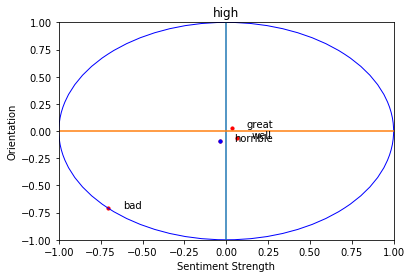

In [76]:
senti(['high'], data_food['preprocessed_sentence'], data_food['preprocessed_sentence_lemma'], False)